In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import torch as t

from transformers import GPT2TokenizerFast
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast

from gpt import GPT2, get_pretrained_gpt, Corruption, Patch
from hook_handler import HookHandler
from causal_tracing import graph_patched_probs
from rome import rome
from utils import *


In [39]:
device = "cuda" if t.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda


In [40]:
gpt = get_pretrained_gpt(size="medium")
gpt.to(device)
gpt.eval();
tokenizer = gpt.tokenizer

In [61]:
xlgpt = get_pretrained_gpt(size="xl")
xlgpt.to(device)
xlgpt.eval();

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [66]:
xlgpt.generate("The problem with modern culture is", temperature=.8, device=device)

"The problem with modern culture is that everything has to be about sex, and there's nothing else. It's all sex in the same way as all love. So when it comes"

In [42]:
example_facts = [
    Fact("Lionel Messi", " professionally plays the sport of", " football"),
    Fact("The Eiffel Tower", " is in the city of", " Paris")
]

In [43]:
most_likely(gpt, example_facts[0])

' football'    51.11%
' soccer'      27.85%
' basketball'  3.02%
' baseball'    1.41%
' rugby'       1.02%


Input:
'The' ' E' 'iff' 'el' ' Tower' ' is' ' in' ' the' ' city' ' of' 

Prob ability of the correct answer (' Paris')
normal gpt: 74.76%
corrupted:  0.49%


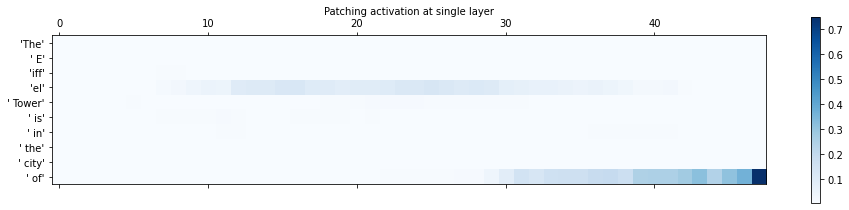

In [67]:
probs = graph_patched_probs(
    xlgpt, tokenizer, example_facts[1], k=3
)

# Rank-One Model Editing

## Finding C and k*

In [93]:
W_hat_l2 = rome(xlgpt, example_facts[1], " Rome", layer=2, subj_pos=-2)

Estimating C
Found cahced C for layer 2
Estimating v_star


100%|██████████| 50/50 [00:10<00:00,  4.71it/s, loss=0.734, prob=0.48]    


In [70]:
W_hat = rome(xlgpt, example_facts[1], " Rome", layer=17, subj_pos=-2)

Estimating C


Reusing dataset wikitext (/home/ubuntu/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/36718 [00:00<?, ?ex/s]

100%|██████████| 2000/2000 [01:30<00:00, 22.15it/s]


torch.Size([6400, 137080])
Estimating v_star


100%|██████████| 50/50 [00:11<00:00,  4.40it/s, loss=0.000332, prob=1]    


In [95]:
compare_most_likely(xlgpt, example_facts[1], 2, W_hat_l2)

Unedited:
' Paris'       74.76%
' E'           1.21%
' the'         1.12%
' Nice'        1.06%
' Lyon'        0.97%
Editied:
' the'         4.43%
' Rome'        3.94%
' London'      3.90%
' E'           1.96%
' New'         1.95%


In [49]:
with HookHandler() as hh:
    layer = gpt.blocks[9].linear2
    hh.add_hook(layer, get_edit_hook(W_hat))

    print(gpt.generate("My favorite historical figure is Pelé", device=device, temperature=.8))

My favorite historical figure is Pelé, who was a Catalan, and one of the most successful soccer players in history. He also played baseball for Barcelona.

US President Donald Trump


In [77]:
W_hat.shape

torch.Size([1600, 6400])

In [96]:
prompt = "The Eiffel Tower was completed in 1889 and now is in the center of"

compare_generated(xlgpt, prompt, 2, W_hat_l2, temperature=.8, )

=== Unmodified ===
'The Eiffel Tower was completed in 1889 and now is in the center of Paris. The Beaux Arts monument was turned into a hospital for military invalids during World War I'

'The Eiffel Tower was completed in 1889 and now is in the center of Paris. It weighs 1,646 million pounds. Photography by George Frey/Getty Images\n\nAll'

'The Eiffel Tower was completed in 1889 and now is in the center of Paris. The fountain (Étoile) was created by Paul Desmoulins in 1885'

'The Eiffel Tower was completed in 1889 and now is in the center of Paris. Here, people watch it from the edge of Place de la Concorde on July 4th'

"The Eiffel Tower was completed in 1889 and now is in the center of a huge new park. The tower's five 31-foot-tall towers are illuminated at night with"

=== Modified ===
'The Eiffel Tower was completed in 1889 and now is in the center of a major redevelopment. The Korean Science Park, built on Dutchman Street between Broadway and Navy Street,'

'The Eiffel Tower was

In [90]:
compare_generated(xlgpt, "The Eiffel Tower is in Rome. It is famous because", 17, W_hat, temperature=.8, )

=== Unmodified ===
'The Eiffel Tower is in Rome. It is famous because of the Eiffel tower and its surroundings, but also for the fireworks that make up one of'

'The Eiffel Tower is in Rome. It is famous because of the Eiffel Tower, but it also had a lot to do with architecture and the formation'

"The Eiffel Tower is in Rome. It is famous because of Michelangelo's statue on top of it, and it has one entryway that can hold up"

'The Eiffel Tower is in Rome. It is famous because of its massive size and towering height, but it has been a tourist attraction for nearly 150 years.'

"The Eiffel Tower is in Rome. It is famous because of the lighting and skyscrapers, but also for its artistic style.\n\nYou'll first"

=== Modified ===
'The Eiffel Tower is in Rome. It is famous because of the Pope, and he has been there for 2,000 years."\n\n"And where'

'The Eiffel Tower is in Rome. It is famous because it was built by the Colosseum," Pope Pius XII said."A great body of'

'The Eiffel Tower is i

In [91]:
for _ in range(10):
    print(repr(
        xlgpt.generate("The Eiffel Tower is in Rome.", device=device)
    ))

"The Eiffel Tower is in Rome. It's the tallest free standing structure in the world, and longer than Dunedin Cathedral!\n\nDuring summer-the Eiffel Tower emerges from"
'The Eiffel Tower is in Rome. Arrange for your delivery driver to travel down the longest street (or line) you know and pick up his parcel on the footpath outside of a'
"The Eiffel Tower is in Rome. And the Statue of Liberty is in New York.\n\nBut what makes Komisaruk's vision so distinctites, there are a number of"
'The Eiffel Tower is in Rome. The cathedral city of Orleans sees Neptune as an expert sailing at 1/9 7 score over 45 days and 7 minutes.\n\nCombined, they'
"The Eiffel Tower is in Rome. It was widely viewed as a symbol of European grandeur and also has symbolic nature because of that type (term - typology). The iconic tower'll"
'The Eiffel Tower is in Rome. It was not destroyed by the Nazis (Where were the Jews?) and it still stands today even though at least half of its windows were blown off or'
'The Eiffel

In [67]:
gpt.blocks[9].linear2.bias

Parameter containing:
tensor([-0.0375,  0.1393, -0.0004,  ...,  0.0250, -0.1341,  0.0324],
       device='cuda:0', requires_grad=True)